In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

**Files description**

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.


### Loading data

In [2]:
data_path = os.path.join('datasets', 'future_sales')

sales_train_path = os.path.join(data_path, 'sales_train.csv')
train_df = pd.read_csv(sales_train_path)

items_path = os.path.join(data_path, 'items.csv')
temp_df = pd.read_csv(items_path)
train_df = pd.merge(train_df, temp_df, on='item_id', how='left')

items_category_path = os.path.join(data_path, 'item_categories.csv')
temp_df = pd.read_csv(items_category_path)
train_df = pd.merge(train_df, temp_df, on='item_category_id', how='left')

shops_path = os.path.join(data_path, 'shops.csv')
temp_df = pd.read_csv(shops_path)
train_df = pd.merge(train_df, temp_df, on='shop_id', how='left')

print('Shape: ', train_df.shape)
train_df.head()

Shape:  (2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


### Data Fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [3]:
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [4]:
train_df['sales'] = train_df['item_price'] * train_df['item_cnt_day']

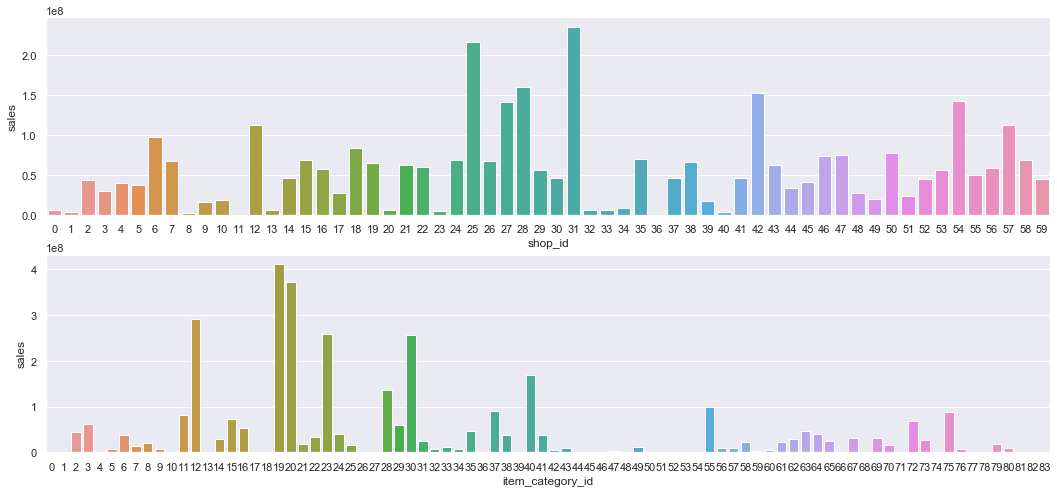

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(18,8))
total_shop = train_df.groupby('shop_id', as_index=False)['sales'].sum()
sns.barplot(x='shop_id', y='sales', data=total_shop, ax=ax[0])

total_shop = train_df.groupby('item_category_id', as_index=False)['sales'].sum()
sns.barplot(x='item_category_id', y='sales', data=total_shop, ax=ax[1])

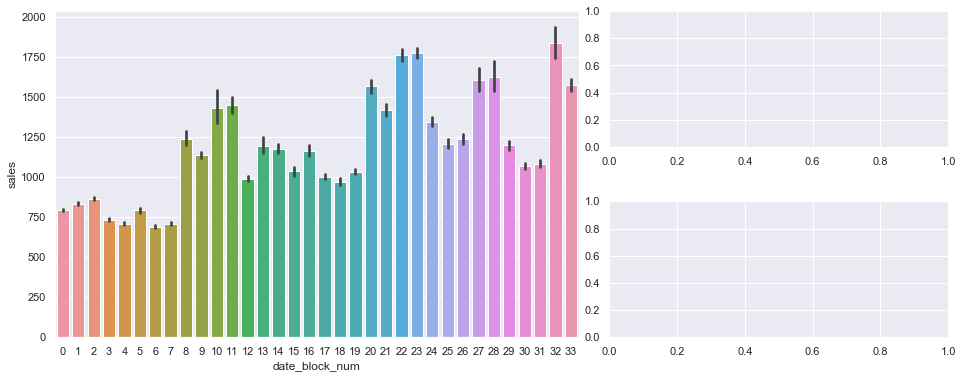

In [6]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(2, 5, hspace=0.4)

ax1 = fig.add_subplot(grid[:, 0:3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, 3:])
date_block_group = train_df.groupby('date_block_num')
sns.barplot(x='date_block_num', y='sales', data=train_df, ax=ax1)

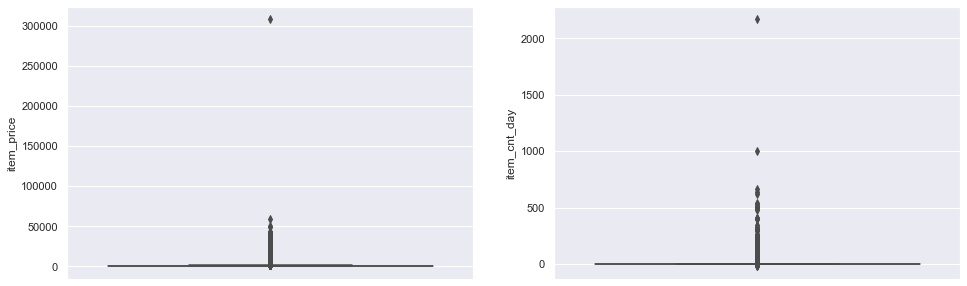

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(y=train_df['item_price'], ax=ax1)
sns.boxplot(y=train_df['item_cnt_day'], ax=ax2)

In [8]:
train_df = train_df.loc[(train_df['item_price'] < 300_000) 
                        & (train_df['item_cnt_day'] < 1000)
                        & (train_df['item_price'] > 0)]

In [9]:
train_df.groupby('shop_name')['shop_id'].nunique().sort_values()

shop_name
!Якутск Орджоникидзе, 56 фран                      1
Москва ТЦ "Серебряный Дом"                         1
Мытищи ТРК "XL-3"                                  1
Н.Новгород ТРЦ "РИО"                               1
Н.Новгород ТРЦ "Фантастика"                        1
Новосибирск ТРЦ "Галерея Новосибирск"              1
Новосибирск ТЦ "Мега"                              1
Омск ТЦ "Мега"                                     1
РостовНаДону ТРК "Мегацентр Горизонт"              1
РостовНаДону ТРК "Мегацентр Горизонт" Островной    1
РостовНаДону ТЦ "Мега"                             1
СПб ТК "Невский Центр"                             1
СПб ТК "Сенная"                                    1
Москва ТЦ "Семеновский"                            1
Самара ТЦ "Мелодия"                                1
Сергиев Посад ТЦ "7Я"                              1
Сургут ТРЦ "Сити Молл"                             1
Томск ТРЦ "Изумрудный Город"                       1
Тюмень ТРЦ "Кристалл"               

In [10]:
train_df['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский" (пав.К7)',
       'Москва ТК "Буденовский" (пав.А2)', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "Новый век" (Новокосино)',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       '!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Жуковский ул. Чкалова 39м?',
       'Казань ТЦ "ПаркХаус" II', 'Казань ТЦ "Бехетле"',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Москва ТЦ "Перловский"',
       'Москва ТЦ "Серебряный Дом"', 'Н.Новгород ТРЦ "Фантастика"',
       '

In [11]:
train_df.loc[train_df['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
train_df.loc[:, 'city'] = train_df['shop_name'].str.split(' ').map(lambda x: x[0])
train_df.loc[train_df['city'] == '!Якутск', 'city'] = 'Якутск'
train_df['city'].nunique()

C:\Users\Bartek\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Bartek\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


31

In [13]:
city_encoder = LabelEncoder()
train_df['city'] = city_encoder.fit_transform(train_df['city'])

C:\Users\Bartek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
cat_encoder = LabelEncoder()
train_df['main_category'] = train_df['item_category_name'].str.split('-').apply(lambda x: x[0])
train_df['main_category_num'] = cat_encoder.fit_transform(train_df['main_category'])

C:\Users\Bartek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Bartek\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
